In [1]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys



def plot_config_snapshot(
        a,
        N_a,
        L,
        T,
        chemical_potential,
        density_compute=True,
        uv=False,
        reuse=False,
        gpu=False,
        progbar=True,
):
    
    cutoff = 3.0  # Cutoff distance for LJ potential
    epsilon = 1.0  # Depth of the potential well/ Energy unit scale
    sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero
    
    beta = 1/T
    tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
        Lx=L,Ly=L,
        beta=beta,
        Nx=N_a,Ny=N_a,
        cutoff=cutoff,
        epsilon=epsilon,
        sigma=sigma,
        uv_cutoff=uv,
        chemical_potential=chemical_potential,
        cyclic=True,
        )
    if gpu:
        import torch
        tn.apply_to_arrays(lambda x: torch.from_numpy(x).cuda())
    # BP
    converged = False
    tol = 1e-5
    count = 0
    max_dm = 0
    damping_eta = 4e-1
    max_dm_cache = 0
    messages_cache = None

    beta = 1/T
    while not converged:

        if count > 0:
            damping_eta += 5e-2
    
        print('Successfully built the HTN.')

        messages, converged, max_dm = qbp.run_belief_propagation(
        tn, 
        tol=tol,
        max_iterations=1500,
        messages=messages_cache,
        progbar=progbar,
        thread_pool=8,
        uniform=False,
        damping=True,
        eta=damping_eta,
        show_max_dm=True,
        )

        max_dm_cache = max_dm

        if reuse:
            messages_cache = messages

        entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)

        density=0
        if density_compute:
            marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
            key_format='s{},{}'
            # Compute the density
            density = 0
            for i in range(N_a):
                for j in range(N_a):
                    key = key_format.format(i,j)
                    density += marginal[key][1]
            density /= L**2
        count += 1
        if count>0:
            break
    
    if gpu:
        density = float(density.cpu().numpy())
        
    print(f'Free entropy from BP: {entropy_bp}, BP density: {density}, T: {T}, chemical_potential: {chemical_potential}')

    if gpu:
        tn.apply_to_arrays(lambda x: x.cpu().numpy())
        for key in messages:
            messages[key] = messages[key].cpu().numpy()


    config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=progbar,damping=True,eta=0.3)
    config_dict=config_dict[0]
    # plot a 2D configuration from the config_dict
    # The keys are the 2d coordinates and the values are the particle types (holes or particles)
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.colors as colors


    # Plot the configuration
    fig, ax = plt.subplots(figsize=(6,6))

    # Plot the lattice grid
    for i in range(N_a):
        ax.plot([i, i], [-1, N_a], color='k', lw=1)
        ax.plot([-1, N_a], [i, i], color='k', lw=1)
    snapshot_density = 0
    # Plot the particles
    pattern = 's{},{}'
    for i in range(N_a):
        for j in range(N_a):
            key = pattern.format(i,j)
            if config_dict[key] == 1:
                ax.scatter(i, j, marker='o', color='g', s=50, label='Particle')
                snapshot_density += 1
            # elif config_dict[key] == 0:
            #     ax.scatter(i, j, marker='o', color='k', s=100)
    snapshot_density /= L**2


    ax.set_xlim(-1, N_a)
    ax.set_ylim(-1, N_a)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(r'T = {}, BP $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}, Snapshot $\rho$ = {}'.format(T, round(density,3), a, L, N_a, snapshot_density))
    plt.show()


def bp_2DLJ_model(
        T, L, N_a,
        chemical_potential=0,
        cutoff=3.0,
        epsilon=1.0,
        sigma=1.0,
        uv=False,
        gpu=False,
        cyclic=True,
        progbar=True,
        density_compute=True,
        converged = False,
        tol = 1e-5,
        max_iterations=1500,
        uniform=False,
        count = 0,
        damping = True,
        damping_eta = 4e-1,
        reuse = False,
        smudge_factor = 1e-3,
):
    beta = 1/T
    tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
        Lx=L,Ly=L,
        beta=beta,
        Nx=N_a,Ny=N_a,
        cutoff=cutoff,
        epsilon=epsilon,
        sigma=sigma,
        uv_cutoff=uv,
        chemical_potential=chemical_potential,
        cyclic=cyclic,
        )
    if gpu:
        import torch
        tn.apply_to_arrays(lambda x: torch.from_numpy(x).cuda())
        
    # BP
    messages_cache = None
    max_dm = 0

    while not converged:

        if count > 0:
            damping_eta += 5e-2
    
        print('Successfully built the HTN.')

        messages, converged, max_dm = qbp.run_belief_propagation(
        tn, 
        tol=tol,
        max_iterations=max_iterations,
        messages=messages_cache,
        progbar=progbar,
        thread_pool=8,
        uniform=uniform,
        damping=damping,
        eta=damping_eta,
        show_max_dm=True,
        smudge_factor=smudge_factor,
        )

        if reuse:
            messages_cache = messages

        entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)

        density=0
        if density_compute:
            marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
            key_format='s{},{}'
            # Compute the density
            density = 0
            for i in range(N_a):
                for j in range(N_a):
                    key = key_format.format(i,j)
                    density += marginal[key][1]
            density /= L**2
        count += 1
        if count>0:
            break
    
    if gpu:
        entropy_bp = float(entropy_bp.cpu().numpy())
        density = float(density.cpu().numpy())
        tn.apply_to_arrays(lambda x: x.cpu().numpy())
        for key in messages:
            messages[key] = messages[key].cpu().numpy()
        for key in marginal:
            marginal[key] = marginal[key].cpu().numpy()
    
    return entropy_bp, marginal, density, max_dm, messages, tn
        

/home/sijingdu/anaconda3/envs/tnmpa/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


## GPU implementation notes

In [2]:
# import torch
# import quimb as qu
# import quimb.tensor as qtn
# import numpy as np
# import tnmpa.solvers.quimb_vbp as qbp
# import sys
# torch.cuda.is_available()
# L = 15
# N_a = 20
# a = L/(N_a-1)
# T = 5
# beta = 1/T
# cutoff = 3.0  # Cutoff distance for LJ potential
# epsilon = 1.0  # Depth of the potential well/ Energy unit scale
# sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero
# uv = False  # Whether to use UV cutoff
# chemical_potential = 0

# tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
#     Lx=L,Ly=L,
#     beta=beta,
#     Nx=N_a,Ny=N_a,
#     cutoff=cutoff,
#     epsilon=epsilon,
#     sigma=sigma,
#     uv_cutoff=uv,
#     chemical_potential=chemical_potential,
#     cyclic=True,
#     )

# tn.apply_to_arrays(lambda x: torch.from_numpy(x).cuda())

## Examples

In [3]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys
def plot_config_snapshot(
        a,
        N_a,
        L,
        T,
        chemical_potential,
        density_compute=True,
        uv=False,
        reuse=False,
        gpu=False,
        progbar=True,
        plot=True,
):
    
    cutoff = 3.0  # Cutoff distance for LJ potential
    epsilon = 1.0  # Depth of the potential well/ Energy unit scale
    sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero
    
    beta = 1/T
    tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
        Lx=L,Ly=L,
        beta=beta,
        Nx=N_a,Ny=N_a,
        cutoff=cutoff,
        epsilon=epsilon,
        sigma=sigma,
        uv_cutoff=uv,
        chemical_potential=chemical_potential,
        cyclic=True,
        )
    if gpu:
        import torch
        tn.apply_to_arrays(lambda x: torch.from_numpy(x).cuda())
    # BP
    converged = False
    tol = 1e-2
    count = 0
    max_dm = 0
    damping_eta = 4e-1
    max_dm_cache = 0
    messages_cache = None

    beta = 1/T
    while not converged:

        if count > 0:
            damping_eta += 5e-2
    
        print('Successfully built the HTN.')

        messages, converged, max_dm = qbp.run_belief_propagation(
        tn, 
        tol=tol,
        max_iterations=1500,
        messages=messages_cache,
        progbar=progbar,
        thread_pool=8,
        uniform=False,
        damping=True,
        eta=damping_eta,
        show_max_dm=True,
        )

        max_dm_cache = max_dm

        if reuse:
            messages_cache = messages

        entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)

        density=0
        if density_compute:
            marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
            key_format='s{},{}'
            # Compute the density
            density = 0
            for i in range(N_a):
                for j in range(N_a):
                    key = key_format.format(i,j)
                    density += marginal[key][1]
            density /= L**2
        count += 1
        if count>0:
            break
    
    if gpu:
        density = float(density.cpu().numpy())
        
    print(f'Free entropy from BP: {entropy_bp}, BP density: {density}, T: {T}, chemical_potential: {chemical_potential}')

    if gpu:
        tn.apply_to_arrays(lambda x: x.cpu().numpy())
        for key in messages:
            messages[key] = messages[key].cpu().numpy()


    config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=progbar,damping=True,eta=0.3)
    config_dict=config_dict[0]
    # plot a 2D configuration from the config_dict
    # The keys are the 2d coordinates and the values are the particle types (holes or particles)
    if plot:
        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)
        snapshot_density = 0
        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=50, label='Particle')
                    snapshot_density += 1
        snapshot_density /= L**2


        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, BP $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}, Snapshot $\rho$ = {}'.format(T, round(density,3), a, L, N_a, snapshot_density))
        plt.show()
    else:
        snapshot_density = 0
        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    snapshot_density += 1
        snapshot_density /= L**2
    return snapshot_density
# a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
# N_a = 20  # Number of lattice points along one direction
# L = a * (N_a - 1)  # Length of the cubic box
import concurrent.futures
def compute_snap_density(_):
    return plot_config_snapshot(
        a,
        N_a,
        L,
        T,
        chemical_potential,
        density_compute=True,
        uv=False,
        reuse=False,
        gpu=False,
        plot=False,
        progbar=False,
    )

snap_density_list = []
snap_density_std_list = []
bp_density_list = []
for N_a in [15]:
    L = 10
    # N_a = 10
    a = L/(N_a-1)
    N = N_a**2  # Total number of lattice
    uv = False  # Whether to use UV cutoff
    density_compute = True
    chemical_potential_list = [0]
    reuse = False
    gpu = True

    dT = 0.1
    # T_list = np.arange(2, 2.5, dT)
    T_list = [10]
    # T_list = np.arange(15.0, 10.0, dT)


    for T in T_list:
        for chemical_potential in chemical_potential_list:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                # Create a list of futures
                futures = [executor.submit(compute_snap_density, _) for _ in range(40)]

                # Retrieve the results as they are completed
                snap_density_l = [future.result() for future in concurrent.futures.as_completed(futures)]

            snap_density_l = np.array(snap_density_l)
            print(np.mean(snap_density_l), np.std(snap_density_l))
            snap_density_list.append(np.mean(snap_density_l))
            snap_density_std_list.append(np.std(snap_density_l))

            entropy_bp, marginal, density, max_dm, messages, tn = bp_2DLJ_model(T, L, N_a)
            bp_density_list.append(density)


Successfully built the HTN.Successfully built the HTN.

Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.Successfully built the HTN.
Successfully built the HTN.Successfully built the HTN.


Successfully built the HTN.Successfully built the HTN.Successfully built the HTN.Successfully built the HTN.Successfully built the HTN.


Successfully built the HTN.


Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.Successfully built the HTN.

Successfully built the HTN.
Free entropy from BP: 93.09515791276408, BP density: 0.5039036734876673, T: 10, chemical_potential: 0
Free entropy from BP: 93.09515791276408, BP density: 0.5039036734876673, T: 10, chemical_potential: 0
Free entropy from BP: 93.09515791276408, BP density: 0.5039036734876673, T: 10, chemical_potential: 0
Free entropy from BP: 93.09515791276408, BP density: 0.5039036734876673, T: 10, chemical_potential: 0
Free entropy from BP: 93.0951579

max_dm=9.906347818972039e-06:   8%|▊         | 125/1500 [00:00<00:02, 478.73it/s]


In [4]:
print(snap_density_list)
print(bp_density_list)

[0.5415]
[0.5036727104046355]


L = 4, T = 3, mu = 0
N_a = 4:
mcmc_rho=0.6449, snap_rho=0.670833, bp_rho=0.643644, a=4/3
N_a = 5:
mcmc_rho=0.9556041666, snap_rho=0.96458333333, bp_rho=0.9595710332118286, a=4/4
N_a = 6:
mcmc_rho=0.8537999, snap_rho=0.870833. bp_rho=0.878405,a=4/5
N_a = 8:
mcmc_rho=0.7107375, snap_rho=0.671875, bp_rho=0.799636,a=4/7
N_a = 10:
mcmc_rho=0.7297375000000172, snap_rho=0.716666, bp_rho=0.977235,a=4/9
N_a = 14:
mcmc_rho=0.7475125000000031, snap_rho=0.7270833, bp_rho=1.193211,a=4/13
N_a = 16:
mcmc_rho=0.756958333333, snap_rho=0.7333333333333, bo_rho=1.4476975436997523,a=4/15

Successfully built the HTN.


max_dm=6.667429585605067e-06:  13%|█▎        | 196/1500 [00:00<00:04, 315.02it/s]


Free entropy from BP: 20165.95925775163, BP density: 0.9849184364419821, T: 3, chemical_potential: 300


s16,0->1: 100%|██████████| 400/400 [00:27<00:00, 14.43it/s] 


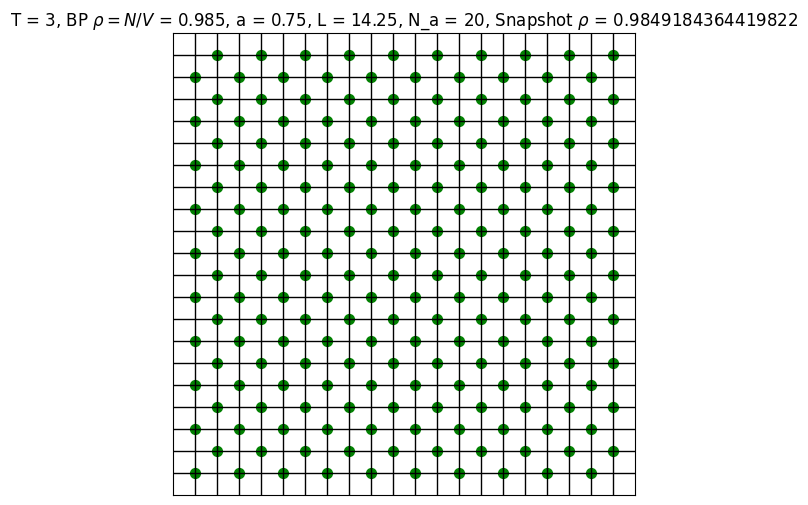

In [83]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys
def plot_config_snapshot(
        a,
        N_a,
        L,
        T,
        chemical_potential,
        density_compute=True,
        uv=False,
        reuse=False,
        gpu=False,
        progbar=True,
):
    
    cutoff = 3.0  # Cutoff distance for LJ potential
    epsilon = 1.0  # Depth of the potential well/ Energy unit scale
    sigma = 1.0  # Length scale in LJ potential, also the distance at which the potential becomes zero
    
    beta = 1/T
    tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
        Lx=L,Ly=L,
        beta=beta,
        Nx=N_a,Ny=N_a,
        cutoff=cutoff,
        epsilon=epsilon,
        sigma=sigma,
        uv_cutoff=uv,
        chemical_potential=chemical_potential,
        cyclic=True,
        )
    if gpu:
        import torch
        tn.apply_to_arrays(lambda x: torch.from_numpy(x).cuda())
    # BP
    converged = False
    tol = 1e-5
    count = 0
    max_dm = 0
    damping_eta = 4e-1
    max_dm_cache = 0
    messages_cache = None

    beta = 1/T
    while not converged:

        if count > 0:
            damping_eta += 5e-2
    
        print('Successfully built the HTN.')

        messages, converged, max_dm = qbp.run_belief_propagation(
        tn, 
        tol=tol,
        max_iterations=1500,
        messages=messages_cache,
        progbar=progbar,
        thread_pool=8,
        uniform=False,
        damping=True,
        eta=damping_eta,
        show_max_dm=True,
        )

        max_dm_cache = max_dm

        if reuse:
            messages_cache = messages

        entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)

        density=0
        if density_compute:
            marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
            key_format='s{},{}'
            # Compute the density
            density = 0
            for i in range(N_a):
                for j in range(N_a):
                    key = key_format.format(i,j)
                    density += marginal[key][1]
            density /= L**2
        count += 1
        if count>0:
            break
    
    if gpu:
        density = float(density.cpu().numpy())
        
    print(f'Free entropy from BP: {entropy_bp}, BP density: {density}, T: {T}, chemical_potential: {chemical_potential}')

    if gpu:
        tn.apply_to_arrays(lambda x: x.cpu().numpy())
        for key in messages:
            messages[key] = messages[key].cpu().numpy()


    config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=progbar,damping=True,eta=0.3)
    config_dict=config_dict[0]
    # plot a 2D configuration from the config_dict
    # The keys are the 2d coordinates and the values are the particle types (holes or particles)
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import matplotlib.colors as colors


    # Plot the configuration
    fig, ax = plt.subplots(figsize=(6,6))

    # Plot the lattice grid
    for i in range(N_a):
        ax.plot([i, i], [-1, N_a], color='k', lw=1)
        ax.plot([-1, N_a], [i, i], color='k', lw=1)
    snapshot_density = 0
    # Plot the particles
    pattern = 's{},{}'
    for i in range(N_a):
        for j in range(N_a):
            key = pattern.format(i,j)
            if config_dict[key] == 1:
                ax.scatter(i, j, marker='o', color='g', s=50, label='Particle')
                snapshot_density += 1
            # elif config_dict[key] == 0:
            #     ax.scatter(i, j, marker='o', color='k', s=100)
    snapshot_density /= L**2


    ax.set_xlim(-1, N_a)
    ax.set_ylim(-1, N_a)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(r'T = {}, BP $\rho=N/V$ = {}, a = {}, L = {}, N_a = {}, Snapshot $\rho$ = {}'.format(T, round(density,3), a, L, N_a, snapshot_density))
    plt.show()

a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 20  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box

# L = 5
# N_a = 11
# a = L/(N_a-1)

N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
# chemical_potential_list = np.arange(10,15,5)
chemical_potential_list = [300]
reuse = False
gpu = True

dT = 0.1
# T_list = np.arange(2, 2.5, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

for T in T_list:
    for chemical_potential in chemical_potential_list:
        plot_config_snapshot(
            a,
            N_a,
            L,
            T,
            chemical_potential,
            density_compute=True,
            uv=False,
            reuse=False,
            gpu=True,
        )


Successfully built the HTN.


max_dm=9.658245147647904e-06:   3%|▎         | 49/1500 [00:00<00:10, 134.38it/s]


Free entropy from BP: 94.35286165573672, BP density: 0.23404043333369387, T: 3, chemical_potential: -5


s17,16->0: 100%|██████████| 625/625 [01:16<00:00,  8.13it/s]


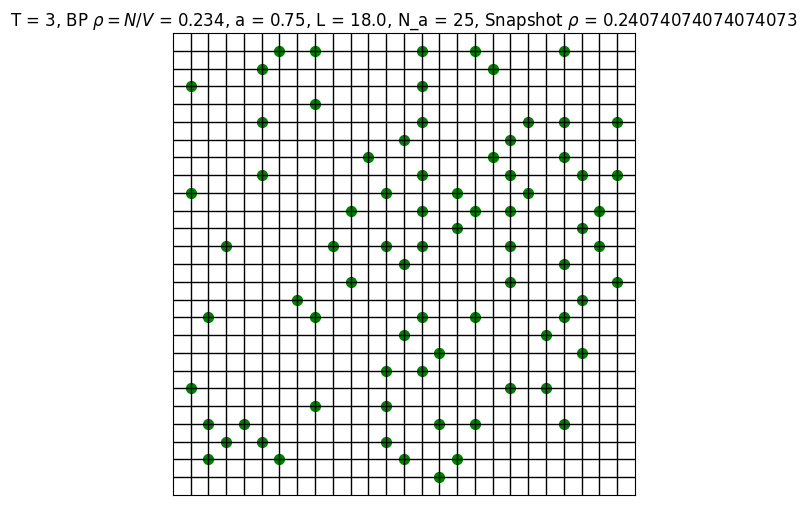

Successfully built the HTN.


max_dm=3.073216012028368e-05: 100%|██████████| 1500/1500 [00:06<00:00, 248.31it/s] 


Free entropy from BP: 314.23392017414545, BP density: 0.6856409041043022, T: 3, chemical_potential: 0


s18,12->1: 100%|██████████| 625/625 [01:14<00:00,  8.42it/s]


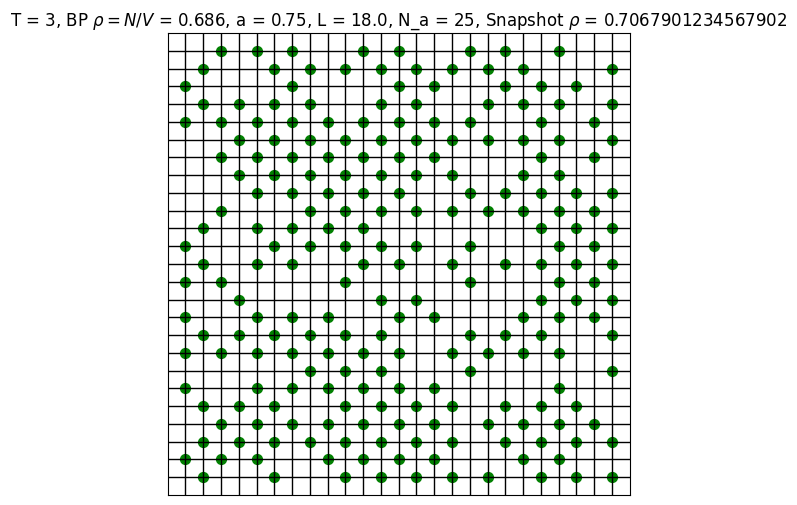

Successfully built the HTN.


max_dm=9.912455520899588e-06:  41%|████      | 615/1500 [00:02<00:03, 227.72it/s] 


Free entropy from BP: 753.3513570344101, BP density: 0.8819909665660608, T: 3, chemical_potential: 5


s23,20->1: 100%|██████████| 625/625 [01:13<00:00,  8.54it/s]


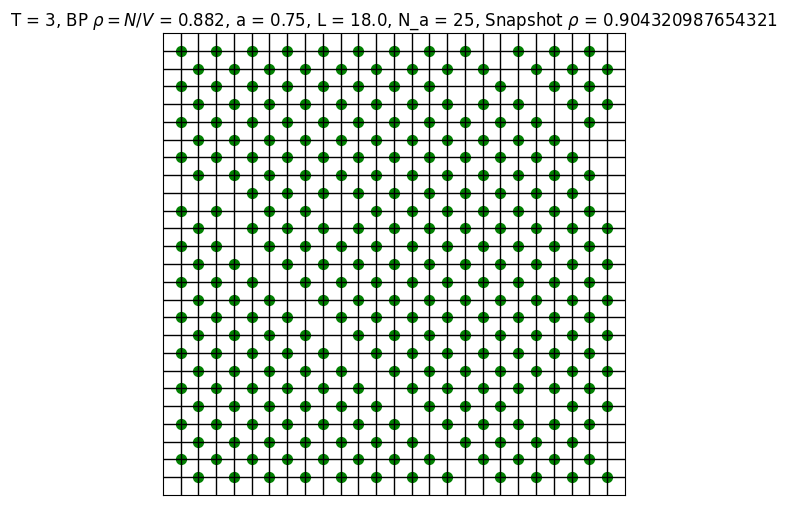

Successfully built the HTN.


max_dm=9.534317742476706e-06:  29%|██▉       | 439/1500 [00:02<00:04, 218.66it/s] 


Free entropy from BP: 1241.4715480090144, BP density: 0.9169748381670848, T: 3, chemical_potential: 10


s4,0->1: 100%|██████████| 625/625 [01:13<00:00,  8.45it/s]  


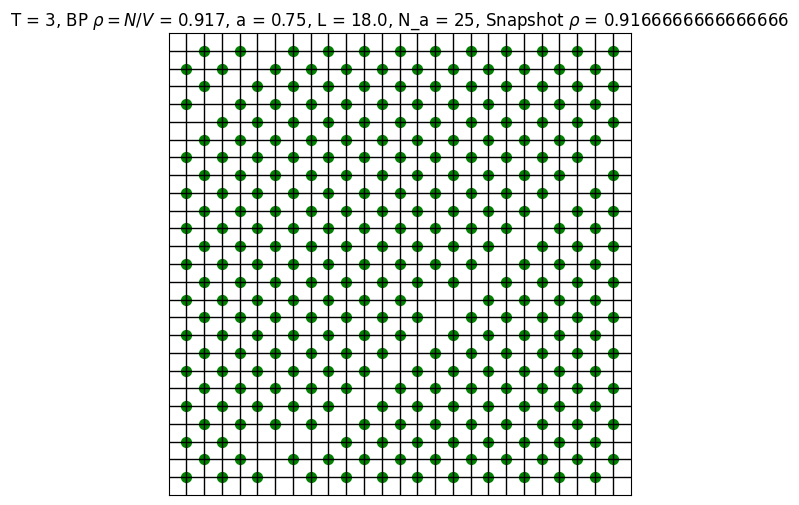

Successfully built the HTN.


max_dm=9.37655367061474e-06:  18%|█▊        | 269/1500 [00:01<00:05, 209.60it/s] 


Free entropy from BP: 2238.6110813037035, BP density: 0.9255901105477045, T: 3, chemical_potential: 20


s15,2->1: 100%|██████████| 625/625 [01:14<00:00,  8.43it/s] 


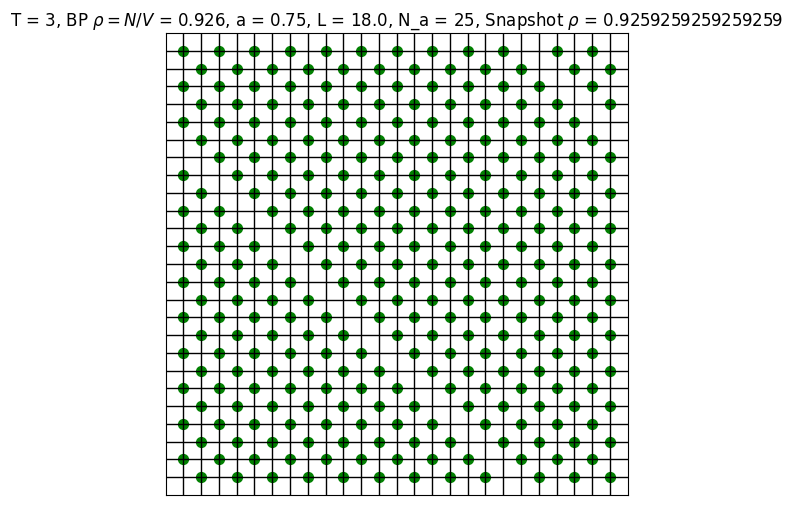

In [9]:
a = 0.75  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 25  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box

# L = 6
# N_a = 20
# a = L/(N_a-1)

N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
# chemical_potential_list = np.arange(10,15,5)
chemical_potential_list = [-5, 0, 5, 10, 20]
reuse = False
gpu = True

dT = 0.1
# T_list = np.arange(2, 2.5, dT)
T_list = [3]
# T_list = np.arange(15.0, 10.0, dT)

for T in T_list:
    for chemical_potential in chemical_potential_list:
        plot_config_snapshot(
            a,
            N_a,
            L,
            T,
            chemical_potential,
            density_compute=True,
            uv=False,
            reuse=False,
            gpu=True,
        )

In [56]:
def bp_2DLJ_model(
        T, L, N_a,
        chemical_potential=0,
        cutoff=3.0,
        epsilon=1.0,
        sigma=1.0,
        uv=False,
        gpu=False,
        cyclic=True,
        progbar=True,
        density_compute=True,
        converged = False,
        tol = 1e-5,
        max_iterations=1500,
        uniform=False,
        count = 0,
        damping = True,
        damping_eta = 4e-1,
        reuse = False,
        smudge_factor = 1e-3,
):
    beta = 1/T
    tn = qtn.tensor_builder.HTN2D_classical_LennardJones_partition_function(
        Lx=L,Ly=L,
        beta=beta,
        Nx=N_a,Ny=N_a,
        cutoff=cutoff,
        epsilon=epsilon,
        sigma=sigma,
        uv_cutoff=uv,
        chemical_potential=chemical_potential,
        cyclic=cyclic,
        )
    if gpu:
        import torch
        tn.apply_to_arrays(lambda x: torch.from_numpy(x).cuda())
        
    # BP
    messages_cache = None
    max_dm = 0

    while not converged:

        if count > 0:
            damping_eta += 5e-2
    
        print('Successfully built the HTN.')

        messages, converged, max_dm = qbp.run_belief_propagation(
        tn, 
        tol=tol,
        max_iterations=max_iterations,
        messages=messages_cache,
        progbar=progbar,
        thread_pool=8,
        uniform=uniform,
        damping=damping,
        eta=damping_eta,
        show_max_dm=True,
        smudge_factor=smudge_factor,
        )

        if reuse:
            messages_cache = messages

        entropy_bp = qbp.compute_free_entropy_from_messages(tn, messages)

        density=0
        if density_compute:
            marginal = qbp.compute_all_index_marginals_from_messages(tn, messages)
            key_format='s{},{}'
            # Compute the density
            density = 0
            for i in range(N_a):
                for j in range(N_a):
                    key = key_format.format(i,j)
                    density += marginal[key][1]
            density /= L**2
        count += 1
        if count>0:
            break
    
    if gpu:
        entropy_bp = float(entropy_bp.cpu().numpy())
        density = float(density.cpu().numpy())
        tn.apply_to_arrays(lambda x: x.cpu().numpy())
        for key in messages:
            messages[key] = messages[key].cpu().numpy()
        for key in marginal:
            marginal[key] = marginal[key].cpu().numpy()
    
    return entropy_bp, marginal, density, max_dm, messages, tn
        

In [84]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

import re

def extract_data(line):
    # Regex pattern to match key-value pairs
    # The pattern now accounts for spaces and special characters in keys
    pattern = r'([\w\s/]+)\s*=\s*([\w\.\-+e]+)'

    data_string = line

    # Find all matches
    matches = re.findall(pattern, data_string)

    # Convert matches to a list of dictionaries
    data = []
    current_dict = {}
    for key, value in matches:
        key = key.strip()  # Remove leading/trailing whitespaces from the key
        if key == 'T':  # New record starts when 'T' is found
            if current_dict:  # If there's a previous record, add it to the list
                data.append(current_dict)
                current_dict = {}
        try:
            # Convert numerical values to float or int
            if '.' in value or 'e' in value:
                current_dict[key] = float(value)
            else:
                current_dict[key] = int(value)
        except ValueError:
            # Keep as string if conversion fails
            current_dict[key] = value

    # Add the last record
    if current_dict:
        data.append(current_dict)

    return data

def plot_config_snapshot(
        a,
        N_a,
        L,
        T,
        chemical_potential,
        density_compute=True,
        uv=False,
        reuse=False,
        gpu=False,
        progbar=True,
        plot_figure=True,
        exact=False
):
    
    def contract_HTN_partition(tn):
        """
        Exactly contract the hyper tensor network to get the partition function.
        """
        import quimb.tensor as qtn
        tensor_list = []
        for tensor in tn.tensor_map.values():
            tensor_list.append(tensor)
        value = qtn.tensor_contract(*tensor_list, output_inds=[])
        return value

    def fix_ind(TN,ind,ind_value):
        """
            Fix the value of an index in a tensor network. Return the modified tensor network with corresponding index dimension reduced to 1.
        """
        tn = TN.copy()
        tn_no_list = list(tn.ind_map[(ind)])
        for tn_no in tn_no_list:
            temp_ind_list = list(tn.tensors[tn_no].inds)
            ind_pos = temp_ind_list.index(ind)
            inds = list(tn.tensors[tn_no].inds)
            inds.pop(ind_pos) # Remove the fixed index
            shape = list(tn.tensors[tn_no].shape)
            shape.pop(ind_pos) # Remove the dimension of the fixed index
            data = tn.tensors[tn_no].data
            # Create a list of slices
            slices = [slice(None)] * data.ndim  # Start with all slices set to ':'
            slices[ind_pos] = slice(ind_value, ind_value + 1)  # Fix the i-th dimension
            new_data = data[tuple(slices)].reshape(shape) # Reduce the dimension of the tensor data
            tn.tensors[tn_no].modify(data=new_data,inds=tuple(inds))
        return tn
    
    entropy_bp, marginal, density, max_dm, messages, tn = bp_2DLJ_model(
        T, L, N_a,
        chemical_potential=chemical_potential,
        cutoff=3.0,
        epsilon=1.0,
        sigma=1.0,
        uv=False,
        gpu=False,
        cyclic=True,
        progbar=True,
        density_compute=True,
    )

    if exact:
        Z0 = contract_HTN_partition(fix_ind(tn,'s0,0',0))
        Z1 = contract_HTN_partition(fix_ind(tn,'s0,0',1))
        exact_density = Z1/(Z0+Z1)
    else:
        exact_density = None
    
    if plot_figure:
        config_dict = qbp.sample_belief_propagation(tn, messages, None,progbar=progbar,damping=True,eta=0.3)
        config_dict=config_dict[0]
        # plot a 2D configuration from the config_dict
    
        # The keys are the 2d coordinates and the values are the particle types (holes or particles)
        import matplotlib.pyplot as plt
        import matplotlib as mpl
        import matplotlib.colors as colors


        # Plot the configuration
        fig, ax = plt.subplots(figsize=(6,6))

        # Plot the lattice grid
        for i in range(N_a):
            ax.plot([i, i], [-1, N_a], color='k', lw=1)
            ax.plot([-1, N_a], [i, i], color='k', lw=1)
        snapshot_density = 0
        # Plot the particles
        pattern = 's{},{}'
        for i in range(N_a):
            for j in range(N_a):
                key = pattern.format(i,j)
                if config_dict[key] == 1:
                    ax.scatter(i, j, marker='o', color='g', s=50, label='Particle')
                    snapshot_density += 1
                # elif config_dict[key] == 0:
                #     ax.scatter(i, j, marker='o', color='k', s=100)
        snapshot_density /= L**2


        ax.set_xlim(-1, N_a)
        ax.set_ylim(-1, N_a)
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(r'T = {}, BP $\rho=N/V$ = {}, a = {}, L = {}, $N_a$ = {}, $\mu$={}, Snapshot $\rho$ = {}'.format(T, round(density,3), a, L, N_a, chemical_potential,snapshot_density))
        plt.show()

    return marginal,density,exact_density



# a = 0.65 # Lattice constant of the underlying simple cubic lattice (in reduced units)
# N_a = 5  # Number of lattice points along one direction
# L = a * (N_a - 1)  # Length of the cubic box

L = 3
N_a = 5
a = L/(N_a-1)

N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
# chemical_potential_list = np.arange(10,15,5)
chemical_potential_list = np.arange(-1,5,0.5)
reuse = False
gpu = True

dT = 0.1
# T_list = np.arange(2, 2.5, dT)
T_list = [2.0]
# T_list = np.arange(15.0, 10.0, dT)

std1_list = []
std2_list = []
bp_density_list = []
exact_density_list = []
weight_list = []

# for a in a_list:
for T in T_list:
    for chemical_potential in chemical_potential_list:
        marginal,bp_density,exact_density = plot_config_snapshot(
            a,
            N_a,
            L,
            T,
            chemical_potential,
            density_compute=True,
            uv=False,
            reuse=False,
            gpu=True,
            plot_figure=False,
            exact=False,
        )
        marginal_list = []
        for key in marginal:
            marginal_list.append(marginal[key])
        marginal_list = np.array(marginal_list)

        col1 = marginal_list[:,0]
        col2 = marginal_list[:,1]
        std1 = np.std(col1)
        std2 = np.std(col2)
        std1_list.append(std1)
        std2_list.append(std2)
        bp_density_list.append(bp_density)
        # exact_density_list.append(exact_density.cpu().numpy())
        # exact_density_list.append(exact_density)

Successfully built the HTN.


max_dm=9.539427990645777e-06:   7%|▋         | 107/1500 [00:00<00:01, 1059.69it/s]


Successfully built the HTN.


max_dm=9.720736697915733e-06:  10%|▉         | 144/1500 [00:00<00:01, 1108.54it/s]


Successfully built the HTN.


max_dm=9.957818199513024e-06:  16%|█▌        | 242/1500 [00:00<00:00, 1767.05it/s]


Successfully built the HTN.


max_dm=9.99999317652378e-06:  61%|██████    | 916/1500 [00:00<00:00, 1088.59it/s]  


Successfully built the HTN.


max_dm=9.994291848502979e-06:  53%|█████▎    | 800/1500 [00:00<00:00, 1121.06it/s] 


Successfully built the HTN.


max_dm=9.939709365913707e-06:  30%|██▉       | 446/1500 [00:00<00:00, 1105.53it/s] 


Successfully built the HTN.


max_dm=9.955642781611651e-06:  24%|██▍       | 361/1500 [00:00<00:01, 1093.33it/s] 


Successfully built the HTN.


max_dm=9.791017281268743e-06:  20%|██        | 300/1500 [00:00<00:01, 1103.94it/s] 


Successfully built the HTN.


max_dm=9.740960023540968e-06:   8%|▊         | 117/1500 [00:00<00:01, 1106.88it/s]


Successfully built the HTN.


max_dm=9.639160944763248e-06:  12%|█▏        | 178/1500 [00:00<00:01, 1112.04it/s]


Successfully built the HTN.


max_dm=9.511876358336835e-06:   6%|▌         | 93/1500 [00:00<00:01, 1101.76it/s]


Successfully built the HTN.


max_dm=9.54026876803793e-06:  10%|▉         | 145/1500 [00:00<00:01, 1034.91it/s] 


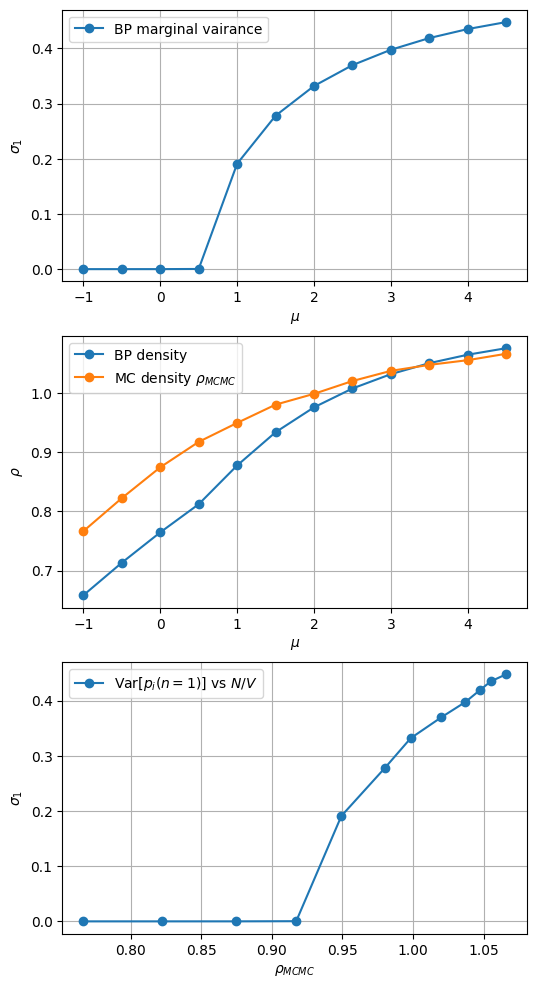

In [86]:
import matplotlib.pyplot as plt

# MC
# Read from file
f = open(f"./MC/Results/2DLJ_occ_L={L}_N_a={N_a}_results_pbc.txt", "r")
lines = f.readlines()
f.close()

T_mc, energy_mc, density_mc, mu_mc = [], [], [], []

for line in lines:
    if line.startswith('T'):
        data = extract_data(line)
        T_mc.append(data[0]['T'])
        energy_mc.append(data[0]['Energy'])
        density_mc.append(data[0]['Density'])
        mu_mc.append(data[0]['chemical potential'])

# plot std1 vs chemical_potential
fig, ax = plt.subplots(3,1,figsize=(6,12))
ax[0].plot(chemical_potential_list,std1_list, marker='o',label=f'BP marginal vairance')
ax[0].set_xlabel(r'$\mu$')
ax[0].set_ylabel(r'$\sigma_1$')
ax[0].legend()

ax[1].plot(chemical_potential_list, bp_density_list, marker='o', label='BP density')
# ax[1].plot(chemical_potential_list, exact_density_list, marker='o', label='Exact density')
ax[1].plot(mu_mc, density_mc, marker='o', label=r'MC density $\rho_{MCMC}$')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\rho$')
ax[1].legend()

ax[2].plot(density_mc, std1_list, marker='o', label='Var[$p_i(n=1)$] vs $N/V$')
ax[2].set_xlabel(r'$\rho_{MCMC}$')
ax[2].set_ylabel(r'$\sigma_1$')
ax[2].legend()

ax[1].grid()
ax[2].grid()
ax[0].grid()

### Convergence analysis

In [68]:
import matplotlib.pyplot as plt
L = 4

# N_a = 10
# a = L/(N_a-1)

# N_a_list = np.arange(5, 20, 1)
N_a_list = [10]

# a = 4/11 # Lattice constant of the underlying simple cubic lattice (in reduced units)
# N_a = 10  # Number of lattice points along one direction
# L = a * (N_a - 1)  # Length of the cubic box

chemical_potential_list = np.arange(-1,5,0.5)
# chemical_potential_list = [0]

dT = 0.25
# T_list = np.arange(0.1, 3, dT)
T_list = [1.5]

max_dm_list = []

for T in T_list:
    for chemical_potential in chemical_potential_list:
        for N_a in N_a_list:
            max_dm_each = []
            for _ in range(10):
                entropy_bp, marginal, density, max_dm, messages, tn = bp_2DLJ_model(
                    T, L, N_a,
                    chemical_potential=chemical_potential,
                    cutoff=3.0,
                    epsilon=1.0,
                    sigma=1.0,
                    uv=False,
                    gpu=False,
                    cyclic=True,
                    progbar=False,
                    density_compute=True,
                    tol=1e-5,
                    max_iterations=200,
                    smudge_factor=1e-12,
                )
                max_dm_each.append(max_dm)
            print(max_dm_each)
            max_dm_list.append([np.average(max_dm_each), np.std(max_dm_each)])



Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
[8.36835709328021e-06, 8.78784426339152e-06, 8.41483688196476e-06, 9.80944315343013e-06, 8.58302486522744e-06, 9.597770476099665e-06, 9.025986288047072e-06, 7.219382924306128e-06, 9.379294503231161e-06, 8.466850229649214e-06]
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
[7.0754061752276165e-06, 7.809057034818823e-06, 9.118242159461554e-06, 7.496039235221907e-06, 8.608199022319685e-06, 7.154236302736594e-06, 6.281479830450021e-06, 6.02392389326134e-06, 7.826294011886725e-06, 7.0216

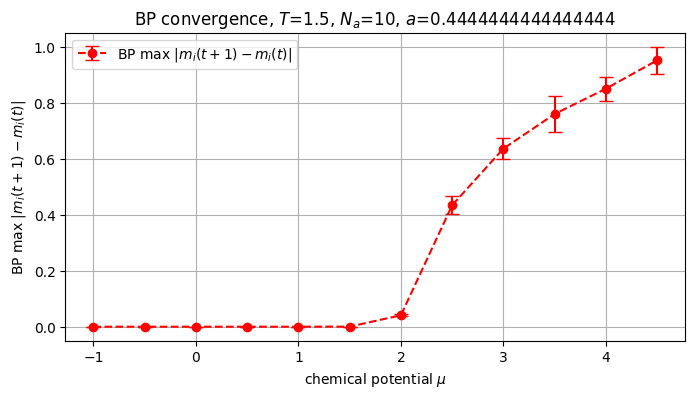

In [74]:
# N_a_list = np.arange(5, 20, 1)
# a_list = L/(N_a_list-1)

fig, ax = plt.subplots(figsize=(8,4))
max_dm_list = np.array(max_dm_list)
max_dm = max_dm_list[:,0]
max_dm_std = max_dm_list[:,1]
# ax.plot(T_list, max_dm, marker='o', label='BP max distance between messages')
# Error bar using standard deviation
# ax.errorbar(T_list, max_dm, yerr=max_dm_std, fmt='--o', label='BP max $|m_i(t+1)-m_i(t)|$', capsize=5, color='b')
# ax.errorbar(a_list, max_dm, yerr=max_dm_std, fmt='--o', label='BP max $|m_i(t+1)-m_i(t)|$', capsize=5, color='g')
ax.errorbar(chemical_potential_list, max_dm, yerr=max_dm_std, fmt='--o', label='BP max $|m_i(t+1)-m_i(t)|$', capsize=5, color='r')


# ax.set_xlabel(r'Temperature $T$')
# ax.set_xlabel(r'Lattice constant $a$')
ax.set_xlabel(r'chemical potential $\mu$')
ax.set_ylabel(r'BP max $|m_i(t+1)-m_i(t)|$')
# ax.set_yscale('log')
ax.legend()
ax.grid()
# ax.set_title(f'BP convergence, $a$={round(a,3)}, $N_a$={L/a+1}, $\mu$={chemical_potential_list[0]}')
# ax.set_title(f'BP convergence, $T$={round(T,3)}, $N_a$={L/a+1}, $\mu$={chemical_potential_list[0]}')
ax.set_title(f'BP convergence, $T$={round(T,3)}, $N_a$={N_a}, $a$={L/(N_a-1)}')
plt.show()

In [134]:
import matplotlib.pyplot as plt
L = 6
N_a_list = np.arange(5, 15, 1)
a_list = L/(N_a_list-1)

# chemical_potential_list = np.arange(-1,5,0.5)
chemical_potential_list = [-5]

dT = 0.25
# T_list = np.arange(0.1, 3, dT)
T_list = [2.0]

max_dm_list = []
density_list = []

for T in T_list:
    for chemical_potential in chemical_potential_list:
        for N_a in N_a_list:
            max_dm_each = []
            density_each = []
            for _ in range(5):
                entropy_bp, marginal, density, max_dm, messages, tn = bp_2DLJ_model(
                    T, L, N_a,
                    chemical_potential=chemical_potential,
                    cutoff=3.0,
                    epsilon=1.0,
                    sigma=1.0,
                    uv=False,
                    gpu=False,
                    cyclic=True,
                    progbar=False,
                    density_compute=True,
                    tol=1e-5,
                    max_iterations=200,
                    smudge_factor=1e-12,
                )
                max_dm_each.append(max_dm)
                density_each.append(density)
            print(max_dm_each, density_each)
            max_dm_list.append([np.average(max_dm_each), np.std(max_dm_each)])
            density_list.append([np.average(density_each), np.std(density_each)])



Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
[7.763635138657854e-06, 7.941606001760082e-06, 9.736448190633684e-06, 9.477836335980427e-06, 9.274600705488911e-06] [0.055765640679605384, 0.0557656459640338, 0.05576565313612082, 0.05576566346881855, 0.05576562673019362]
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
[9.793392684864788e-06, 7.981104941268136e-06, 6.766700741844822e-06, 7.492741823822424e-06, 6.463076831497716e-06] [0.09417634556403101, 0.09417612350714835, 0.09417611996892933, 0.094176202260074, 0.09417610047414064]
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
Successfully built the HTN.
[6.479299269335215e-06, 5.526871073524564e-06, 7.2464327405818985e-06, 6.1202242412905505e-06, 8.361126926537121e-06] [0.11336512886738699

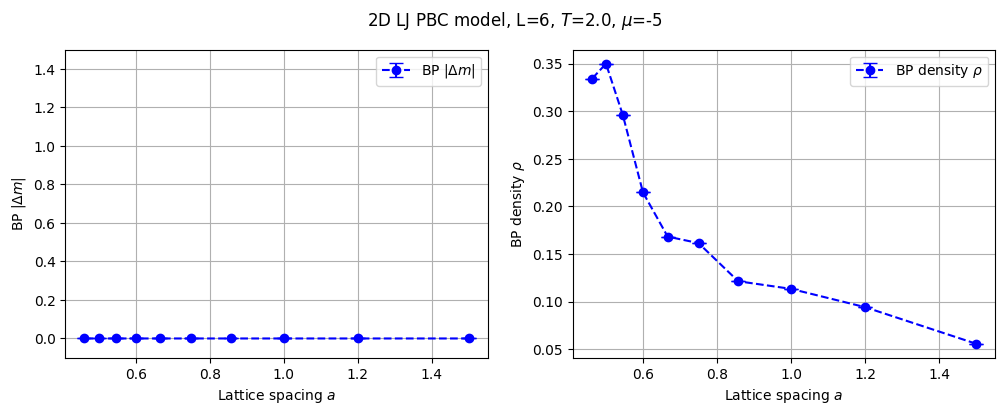

In [135]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
max_dm_list = np.array(max_dm_list)
max_dm = max_dm_list[:,0]
max_dm_std = max_dm_list[:,1]

density_list = np.array(density_list)
density = density_list[:,0]
density_std = density_list[:,1]
# ax[0].plot(T_list, max_dm, marker='o', label='BP max distance between messages')
# Error bar using standard deviation
ax[0].errorbar(a_list, max_dm, yerr=max_dm_std, fmt='--o', label=r'BP $|\Delta m|$', capsize=5, color='b')
ax[1].errorbar(a_list, density, yerr=density_std, fmt='--o', label=r'BP density $\rho$', capsize=5, color='b')


ax[0].set_xlabel(r'Lattice spacing $a$')
ax[0].set_ylabel(r'BP $|\Delta m|$')
# ax[0].set_yscale('log')
ax[0].legend()
ax[0].grid()
# ax[0].set_title(f'2D LJ PBC model, L={L}, $T$={T_list[0]}, $\mu$={chemical_potential_list[0]}')

ax[1].set_xlabel(r'Lattice spacing $a$')
ax[1].set_ylabel(r'BP density $\rho$')
# ax[1].set_yscale('log')
ax[1].legend()
ax[1].grid()
ax[0].set_ylim(-0.1, 1.5)
# ax[1].set_title(f'2D LJ PBC model, L={L}, $T$={T_list[0]}, $\mu$={chemical_potential_list[0]}')
# Set title
plt.suptitle(f'2D LJ PBC model, L={L}, $T$={T_list[0]}, $\mu$={chemical_potential_list[0]}')
plt.show()

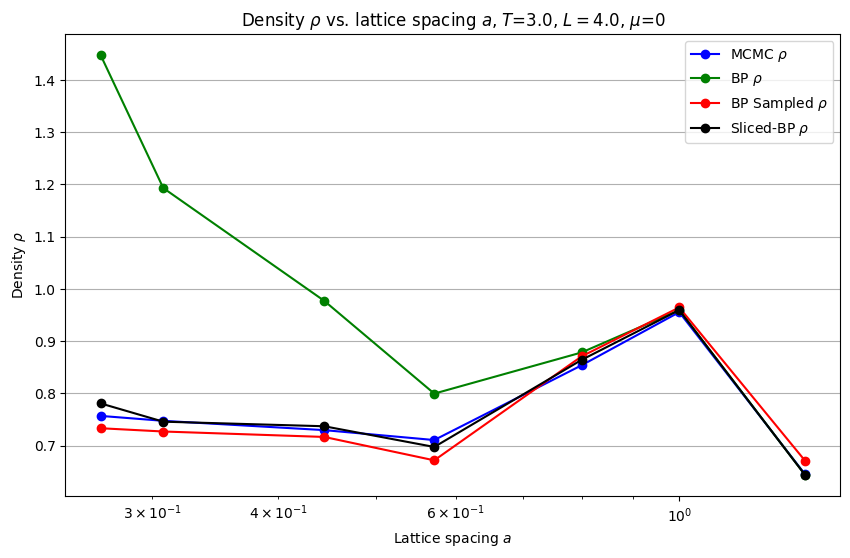

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data provided
data = {
    r"N_a": [4, 5, 6, 8, 10, 14, 16],
    r'$a$': [4/3, 4/4, 4/5, 4/7, 4/9, 4/13, 4/15],
    r"MCMC $\rho$": [0.6449, 0.9556041666, 0.8537999, 0.7107375, 0.7297375000000172, 0.7475125000000031, 0.756958333333],
    r"BP $\rho$": [0.643644, 0.9595710332118286, 0.878405, 0.799636, 0.977235, 1.193211, 1.4476975436997523],  # None for missing value
    r"BP Sampled $\rho$": [0.670833, 0.96458333333, 0.870833, 0.671875, 0.716666, 0.7270833, 0.7333333333333],
    r"Sliced-BP $\rho$": [0.6435695426333327, 0.9595277783600216, 0.8641515926061387, 0.6974873445561329, 0.7371345634592132, 0.7459128652920048, 0.7808614507486175]
}

# Convert to DataFrame for easier handling
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))

color_list = ['b','g','r','k']

for column in df.columns[2:]:
    plt.plot(df['$a$'], df[column], marker='o', label=column, color=color_list.pop(0))

plt.title(r'Density $\rho$ vs. lattice spacing $a$, $T$=3.0, $L=4.0$, $\mu$=0')
plt.xlabel(r'Lattice spacing $a$')
plt.xscale('log')
plt.ylabel(r'Density $\rho$')
plt.legend()
plt.grid(axis='y')
plt.show()


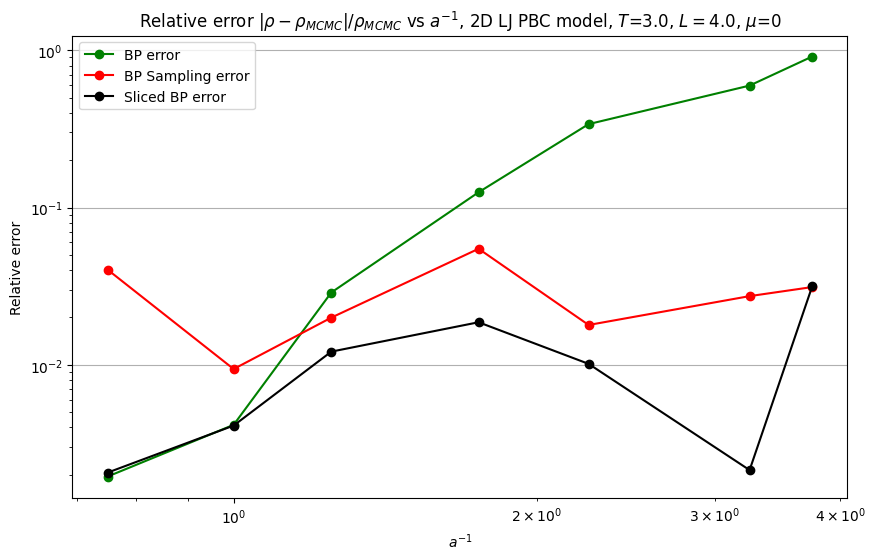

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Data provided
data = {
    r"N_a": [4, 5, 6, 8, 10, 14, 16],
    r'$a$': [4/3, 4/4, 4/5, 4/7, 4/9, 4/13, 4/15],
    r"MCMC $\rho$": [0.6449, 0.9556041666, 0.8537999, 0.7107375, 0.7297375000000172, 0.7475125000000031, 0.756958333333],
    r"BP $\rho$": [0.643644, 0.9595710332118286, 0.878405, 0.799636, 0.977235, 1.193211, 1.4476975436997523],  # None for missing value
    r"BP Sampled $\rho$": [0.670833, 0.96458333333, 0.870833, 0.671875, 0.716666, 0.7270833, 0.7333333333333],
    r"Sliced-BP $\rho$": [0.6435695426333327, 0.9595277783600216, 0.8641515926061387, 0.6974873445561329, 0.7371345634592132, 0.7459128652920048, 0.7808614507486175],
    "p": [0.3,0.3,0.3,0.2,0.1,6/14**2,5/16**2]
}

mcmc_density = np.array(data[r"MCMC $\rho$"])
bp_density = np.array(data[r"BP $\rho$"])
bp_sampled_density = np.array(data[r"BP Sampled $\rho$"])
sliced_bp_density = np.array(data[r"Sliced-BP $\rho$"])
a_inverse_list = np.array(data[r'$a$'])**(-1)
N_a_list = np.array(data[r'N_a'])

error_bp = np.abs(bp_density - mcmc_density)/mcmc_density
error_bp_sampled = np.abs(bp_sampled_density - mcmc_density)/mcmc_density
error_sliced_bp = np.abs(sliced_bp_density - mcmc_density)/mcmc_density

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(a_inverse_list, error_bp, marker='o', label=r'BP error', color='g')
plt.plot(a_inverse_list, error_bp_sampled, marker='o', label=r'BP Sampling error', color='r')
plt.plot(a_inverse_list, error_sliced_bp, marker='o', label=r'Sliced BP error', color='k')

# # label each error_sliced_bp point with p
# for i, txt in enumerate(data["p"]):
#     plt.annotate(txt, (a_inverse_list[i], error_sliced_bp[i]))

plt.title(r'Relative error $|\rho-\rho_{MCMC}|/\rho_{MCMC}$ vs $a^{-1}$, 2D LJ PBC model, $T$=3.0, $L=4.0$, $\mu$=0')
plt.xlabel(r'$a^{-1}$')
plt.xscale('log')
plt.ylabel(r'Relative error')
plt.yscale('log')
plt.legend()
plt.grid(axis='y')



Successfully built the HTN.


max_dm=9.811054047348389e-06:  33%|███▎      | 493/1500 [00:03<00:06, 149.37it/s] 


Free entropy from BP: 12145.777093157569, BP density: 1.2408880488687801, T: 5, chemical_potential: 210


s22,9->0: 100%|██████████| 625/625 [01:49<00:00,  5.72it/s] 


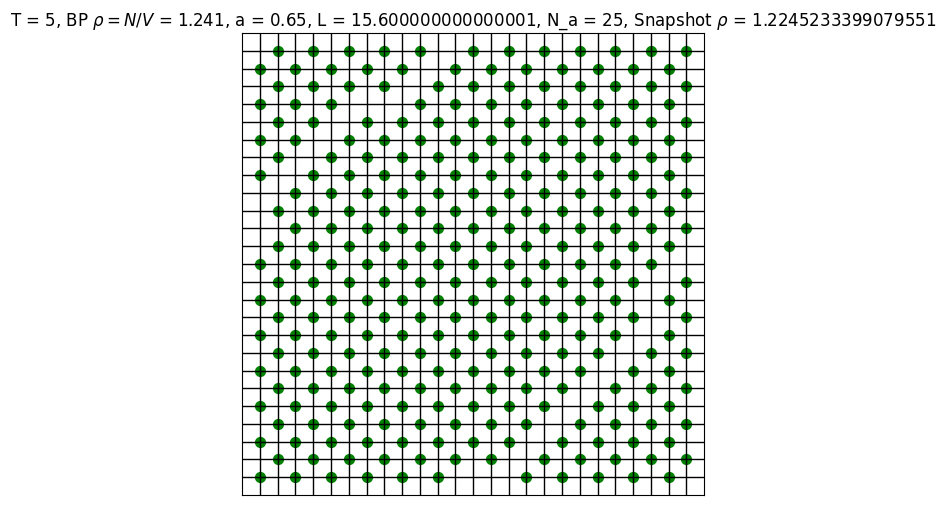

In [9]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import tnmpa.solvers.quimb_vbp as qbp
import sys

a = 0.65  # Lattice constant of the underlying simple cubic lattice (in reduced units)
N_a = 25  # Number of lattice points along one direction
L = a * (N_a - 1)  # Length of the cubic box

# L = 10
# N_a = 25
# a = L/(N_a-1)

N = N_a**2  # Total number of lattice
uv = False  # Whether to use UV cutoff
density_compute = True
# chemical_potential = 5
# chemical_potential_list = np.arange(10,15,5)
chemical_potential_list = [210]
reuse = False
gpu = True

dT = 0.1
# T_list = np.arange(2, 2.5, dT)
T_list = [5]
# T_list = np.arange(15.0, 10.0, dT)


for T in T_list:
    for chemical_potential in chemical_potential_list:
        plot_config_snapshot(
            a,
            N_a,
            L,
            T,
            chemical_potential,
            density_compute=True,
            uv=False,
            reuse=False,
            gpu=True,
        )
